**@author: James V. Talwar**
    
# Investigating Immune Infiltration: MHC-I AI Carriers and CD8+ T-cell and Regulatory T-cell Infiltration 

**About:**  This notebook provides the code needed to generate all immune infiltration analyses reported in the paper [*Autoimmune Alleles at the Major Histocompatibility Locus Modify Melanoma Susceptibility*](https://www.biorxiv.org/content/10.1101/2021.08.12.456166v1.full). In particular these analyses span the following figures: **Figure 1B**, **Figure 1F**, **Figure 3J**, **Supplementary Figure 5F-G**, and **Supplementary Figure 15**. Succinctly, this notebook investigates and quantifies whether carriers of MHC-I alleles associated with skin-specific (vitiligo, psoriasis) CD8+ T-cell mediated autoimmune conditions associate with increased CD8+ T-cell infiltration and decreased regulatory T-cell infiltration in primary melanoma tumors in the TCGA (N = 103).    

## 1. Import Packages and Load in Preprocessed Data

In [1]:
import pandas as pd
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import statsmodels.formula.api as smf
import tqdm
import joblib
import os
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import string
import matplotlib.gridspec as gridspec

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger()
console = logging.StreamHandler()
logger.addHandler(console)

In [3]:
#get AI alleles
autoimmuneAlleles = set(pd.read_csv("../Data/AutoimmuneAlleles.tsv", sep = "\t", header = None)[0].tolist())
autoimmuneAlleles

{'HLA-B13:02',
 'HLA-B27:05',
 'HLA-B39:06',
 'HLA-B51:01',
 'HLA-B57:01',
 'HLA-C06:02',
 'HLA-C12:03'}

Load in TCGA SKCM data:

In [4]:
tcgaSummary = pd.read_csv("../GenotypeData/TCGA_Summary_With_BRAFV600E_Mutation_Status.tsv", index_col = 0, sep = "\t")

#Filter out individuals < 20 years old given increased likelihood of rare germline predisposing variants.
tcgaSummary = tcgaSummary[tcgaSummary.Age >= 20]

#Get the total number of class-I AI alleles per individual
numTotalAIAlleles = []
for i,row in tcgaSummary.iterrows():
    howManyTotal = 0
    for allele in row["A1":"C2"]:
        if allele in autoimmuneAlleles:
            howManyTotal += 1
    numTotalAIAlleles.append(howManyTotal)
    
tcgaSummary["NumProtectiveAlleles"] = numTotalAIAlleles

#Ensure AI Allele Status is correct
tcgaSummary["HasProtection"] = [(len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0) for i,row in tcgaSummary.iterrows()]

#Obtain HLA-A02:01 status:
tcgaSummary["HasA0201"] = [(len(set(row["A1":"C2"]).intersection({"HLA-A02:01"})) > 0) for i, row in tcgaSummary.iterrows()]

#Obtain HLA-A02:01 Only status (i.e., no AI allele carried)
tcgaSummary["OnlyA0201"] = [bool((len(set(row["A1":"C2"]).intersection({"HLA-A02:01"})) > 0) & ~((len(set(row["A1":"C2"]).intersection(autoimmuneAlleles)) > 0))) for i,row in tcgaSummary.iterrows()]

Load in precomputed neoantigen burdens for SKCM TCGA individuals (*see Preprocessing/GenerateAllMutationBRScoresAndNeoantigenBurdens.ipynb*)
 - **NOTE**: If utilize any analyses with mutation burden and infiltration - use `TotalMutations` column (which is the total number of joint DNA and RNA mutations - gives clearer sense of potentially presentable mutations).

In [5]:
neoantigenBurdens = pd.read_csv("../GenotypeData/NeoantigenBurdens_SKCM_TCGA.tsv", sep = "\t", index_col = 0) 
neoantigenBurdens["WeakBindingDifference"] = neoantigenBurdens["WeakBinding_PHBR-I_2"] - neoantigenBurdens["StrongBinding_PHBR-I_0.5"] #Subtract out those mutations that are also strong binders as will; Gives non-overlapping bucket

In [6]:
#Add neoantigen burden and V600E presentability information to summary dataframe
tcgaSummary = pd.concat([tcgaSummary, neoantigenBurdens], join = "inner", axis = 1)

Load in precomputed TCGA CIBERSORTx results and extract primary tumor SKCM individuals. Primary SKCM tumors were assessed by:
 - Use of TCGA Barcode mapping which indicates state of tumor at time of sequencing
  - TCGA Sample Mappings Explained (used to extract primary): https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes <br>
  - TCGA Barcodes Explained: https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/

In [7]:
#Get CIBERSORTx Results
lightCiber = pd.read_csv("../GenotypeData/tcgaCibersortXResults.txt", sep="\t", index_col = 0)

In [8]:
masterDF = pd.concat([tcgaSummary, lightCiber], join = "inner", axis = 1)

#one individual has NaN value (4 mutations total with no valid mutations as defined by pre-processing pipeline); Fill NaN value with 0
masterDF["StrongBinding_PHBR-I_0.5"].fillna(0, inplace = True) 
masterDF["WeakBinding_PHBR-I_2"].fillna(0, inplace = True)
masterDF["WeakBindingDifference"].fillna(0, inplace = True)

#In case want fractional burden (i.e., how many mutations an individual has are neoantigens) rather than absolute number
masterDF["StrongNeoantigenMutationFraction"] = masterDF["StrongBinding_PHBR-I_0.5"]/masterDF["TotalMutations"]
masterDF["WeakNeoantigenMutationFraction"] = masterDF["WeakBinding_PHBR-I_2"]/masterDF["TotalMutations"]
masterDF["CD8_Treg_Ratio"] = masterDF["T cells CD8"]/(masterDF["T cells regulatory (Tregs)"] + 0.01) #add denom pseudo count of 1% to prevent NaNs and infs

#Add columns for visualization and modeling  
masterDF["PlottingNumTotalAIAlleles"] = ["3+" if el >= 3 else str(el) for el in masterDF.NumProtectiveAlleles]
masterDF["BinarizedV600EStatus"] = masterDF.HasBRAFV600E.astype(int)
masterDF["NonV600EAndProtection"] = masterDF.HasProtection & (~masterDF.HasBRAFV600E)

logging.info("Infiltration Results Exist for N = {} SKCM TCGA Individuals".format(masterDF.shape[0]))

Infiltration Results Exist for N = 103 SKCM TCGA Individuals


## 2. CD8+ T-Cell Infiltration Analyses:

### Figure 1F: CD8+ T-cell Infiltration and the Number of AI Alleles 

Text(-0.29, 0.123, '0.12')

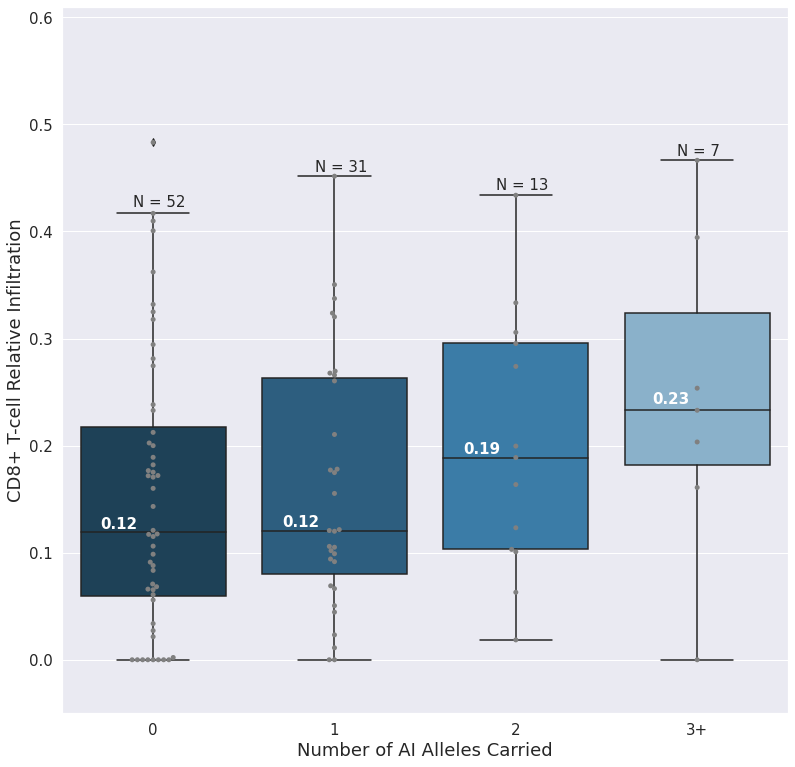

In [9]:
colorPalette = {"0":"#154360" , "1":"#1F618D", "2":"#2980B9" , "3+":"#7FB3D5"}
sns.set(font_scale = 1.1)
plt.figure(figsize=(13,13))
ax = sns.boxplot(data = masterDF, x = "PlottingNumTotalAIAlleles", y = "T cells CD8", order = ["0", "1", "2", "3+"], palette = colorPalette)
sns.swarmplot(data = masterDF, x = "PlottingNumTotalAIAlleles", y = "T cells CD8", color = "grey", dodge = True, order = ["0", "1", "2", "3+"])

plt.xlabel("Number of AI Alleles Carried", fontsize = 18)
plt.ylabel("CD8+ T-cell Relative Infiltration", fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylim(-0.05, 0.61)

offset = -0.11
plt.text(0 + offset, .423, "N = {}".format(masterDF[masterDF.PlottingNumTotalAIAlleles == "0"].shape[0]), fontsize = 15)
plt.text(1 + offset, .456, "N = {}".format(masterDF[masterDF.PlottingNumTotalAIAlleles == "1"].shape[0]), fontsize = 15)
plt.text(2 + offset, .439, "N = {}".format(masterDF[masterDF.PlottingNumTotalAIAlleles == "2"].shape[0]), fontsize = 15)
plt.text(3 + offset, .471, "N = {}".format(masterDF[masterDF.PlottingNumTotalAIAlleles == "3+"].shape[0]), fontsize = 15)

plt.text(2.75, 0.239, "{0:.2f}".format(np.median(masterDF[masterDF.PlottingNumTotalAIAlleles == "3+"]["T cells CD8"])), color = "white", weight = "bold", fontsize = 15)
plt.text(1.71, 0.193, "{0:.2f}".format(np.median(masterDF[masterDF.PlottingNumTotalAIAlleles == "2"]["T cells CD8"])), color = "white", weight = "bold", fontsize = 15)
plt.text(.71, 0.125, "{0:.2f}".format(np.median(masterDF[masterDF.PlottingNumTotalAIAlleles == "1"]["T cells CD8"])), color = "white", weight = "bold", fontsize = 15)
plt.text(-0.29, 0.123, "{0:.2f}".format(np.median(masterDF[masterDF.PlottingNumTotalAIAlleles == "0"]["T cells CD8"])), color = "white", weight = "bold", fontsize = 15)

**Regression modeling with number of AI alleles carried:**

$$\text{CD8+ T-cell Infiltration} \sim \text{Number of AI Alleles Carried} $$

In [10]:
numAllelesAndInfiltration = smf.ols(formula= "Q('T cells CD8') ~ NumProtectiveAlleles", data=masterDF).fit() #, groups=valOnly["Study"]).fit() #smf.mixedlm(formula='zAge ~ zProtection', data=valOnly, groups=valOnly["Study"]).fit() 
summary = numAllelesAndInfiltration.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1464,0.016,9.245,0.000,0.115,0.178
NumProtectiveAlleles,0.0270,0.013,2.081,0.040,0.001,0.053


In [11]:
numAllelesAndInfiltration.conf_int()*100 #Confidence interval as a percentage

,0,1
Intercept,11.499121,17.782501
NumProtectiveAlleles,0.126626,5.282072


In [12]:
logging.info("CD8+ per AI allele carried infiltration: {0:.5f}%; p-value: {1:.5f}".format(numAllelesAndInfiltration.params["NumProtectiveAlleles"]*100, numAllelesAndInfiltration.pvalues["NumProtectiveAlleles"]))

CD8+ per AI allele carried infiltration: 2.70435%; p-value: 0.03995


**Regression modeling with number of AI alleles carried and TMB:**

$$\text{CD8+ T-cell Infiltration} \sim \text{Number of AI Alleles Carried} + \text{TMB} $$

In [13]:
numAllelesAndTMB =  smf.ols(formula= "Q('T cells CD8') ~ NumProtectiveAlleles +  TotalMutations", data=masterDF).fit()
summary = numAllelesAndTMB.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1432,0.018,8.162,0.000,0.108,0.178
NumProtectiveAlleles,0.0265,0.013,2.027,0.045,0.001,0.053
TotalMutations,1.576e-05,3.59e-05,0.439,0.662,-5.56e-05,8.71e-05


In [14]:
numAllelesAndTMB.conf_int()*100 #Confidence interval as a percentage

,0,1
Intercept,10.836056,17.796104
NumProtectiveAlleles,0.056497,5.252804
TotalMutations,-0.005555,0.008708


In [15]:
logging.info("CD8+ per AI allele carried infiltration: {0:.5f}%; p-value: {1:.5f}".format(numAllelesAndTMB.params["NumProtectiveAlleles"]*100, numAllelesAndTMB.pvalues["NumProtectiveAlleles"]))

CD8+ per AI allele carried infiltration: 2.65465%; p-value: 0.04531


**Regression modeling with number of AI alleles carried, neoantigen burden (including strongly and non-intersecting weakly binding neoantigens), BRAFV600E mutation status, and ability to strongly present BRAFV600E when harboring this mutation:**

$$\text{CD8+ T-cell Infiltration} \sim \text{Number of AI Alleles Carried} + \text{Number of Strongly Presentable Neoantigens} + \text{Number of Weakly Presentable Neoantigens} + \text{BRAFV600E Status} + \text{BRAFV600E Status}*\text{Can Strongly Present BRAFV600E}$$

In [16]:
#Accounting for both use WeakBindingDifference (non-intersecting with strong binders) - don't want to double count strong binders in weak binders  
everythingAndNumAlleles =  smf.ols(formula= "Q('T cells CD8') ~ NumProtectiveAlleles +  Q('StrongBinding_PHBR-I_0.5') +  WeakBindingDifference + BinarizedV600EStatus:StrongV600EPresentation + BinarizedV600EStatus", data=masterDF).fit()
summary = everythingAndNumAlleles.summary()
summary.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1489,0.021,7.182,0.000,0.108,0.190
NumProtectiveAlleles,0.0275,0.013,2.091,0.039,0.001,0.054
Q('StrongBinding_PHBR-I_0.5'),0.0021,0.002,1.390,0.168,-0.001,0.005
WeakBindingDifference,-0.0012,0.001,-1.340,0.183,-0.003,0.001
BinarizedV600EStatus:StrongV600EPresentation,0.1058,0.128,0.830,0.409,-0.147,0.359
BinarizedV600EStatus,-0.0222,0.026,-0.863,0.390,-0.073,0.029


In [17]:
everythingAndNumAlleles.conf_int().loc["NumProtectiveAlleles"]*100 #Confidence interval as a percentage

0    0.139575
1    5.352804
Name: NumProtectiveAlleles, dtype: float64

In [18]:
logging.info("CD8+ per AI allele carried infiltration: {0:.5f}%; p-value: {1:.5f}".format(everythingAndNumAlleles.params["NumProtectiveAlleles"]*100, everythingAndNumAlleles.pvalues["NumProtectiveAlleles"]))

CD8+ per AI allele carried infiltration: 2.74619%; p-value: 0.03914


### Figure 3J: CD8+ T-cell Infiltration in AI Allele Carriers Without V600E Mutation 

Statistical Test: MWU test for CD8+ T-cell infiltration

In [19]:
#run statistical test
_, pCD8AINoBRAF = mannwhitneyu(masterDF[(masterDF.NonV600EAndProtection)]["T cells CD8"], masterDF[(masterDF["NonV600EAndProtection"] == False)]["T cells CD8"])
logging.info(f"MWU Test p-value: {pCD8AINoBRAF}")

MWU Test p-value: 0.040706141152694136


Text(-0.75, 0.63, 'J')

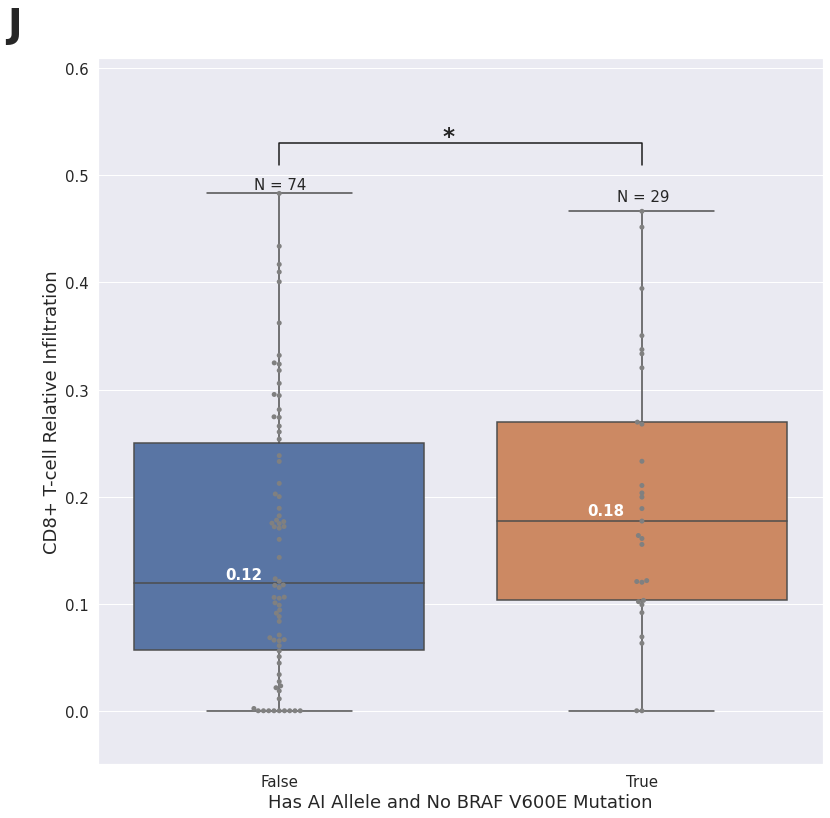

In [20]:
plt.figure(figsize = (13, 13))

ax = sns.boxplot(x = "NonV600EAndProtection", y = "T cells CD8", data = masterDF)
sns.swarmplot(x = "NonV600EAndProtection", y = "T cells CD8", data = masterDF, dodge = True, color = "grey")
plt.ylim(-0.05, 0.61)

plt.xlabel("Has AI Allele and No BRAF V600E Mutation", fontsize = 18)
plt.ylabel("CD8+ T-cell Relative Infiltration", fontsize = 18)
#plt.text(0.35, 0.45, "p = {0:.3f}".format(pCD8AINoBRAF), fontsize = 15, fontweight = "bold")

plt.text(0.93, .476, "N = {}".format(masterDF[masterDF.NonV600EAndProtection].shape[0]), fontsize = 15)
plt.text(-0.07, .487, "N = {}".format(masterDF[~masterDF.NonV600EAndProtection].shape[0]), fontsize = 15)

plt.text(0.85, .183, "{0:.2f}".format(np.median(masterDF[masterDF.NonV600EAndProtection]["T cells CD8"])), color = "white", fontsize = 15, fontweight = "bold")
plt.text(-0.15, .123, "{0:.2f}".format(np.median(masterDF[~masterDF.NonV600EAndProtection]["T cells CD8"])), color = "white", fontsize = 15, fontweight = "bold")


plt.plot([0,0,1,1], [0.51, 0.53, 0.53, 0.51], lw = 1.5, c = 'k')
plt.text(0.45, 0.53, "*", fontsize = 23, fontweight = "bold")


for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
ax.text(-0.75, 0.63, string.ascii_uppercase[9], size=39, weight='bold')

### Supplementary Figure 15: CD8+ T-cell Infiltration in A)  MHC-I AI Carriers B) BRAFV600E Harborers 

#### Supplementary Figure 15A:

Statistical Test: MWU test for CD8+ T-cell infiltration

In [21]:
#run statistical test
_, pCD8AndAI = mannwhitneyu(masterDF[(masterDF.HasProtection)]["T cells CD8"], masterDF[(masterDF["HasProtection"] == False)]["T cells CD8"])
logging.info(f"MWU Test p-value: {pCD8AndAI}")

MWU Test p-value: 0.08961691801091226


Text(-0.75, 0.63, 'A')

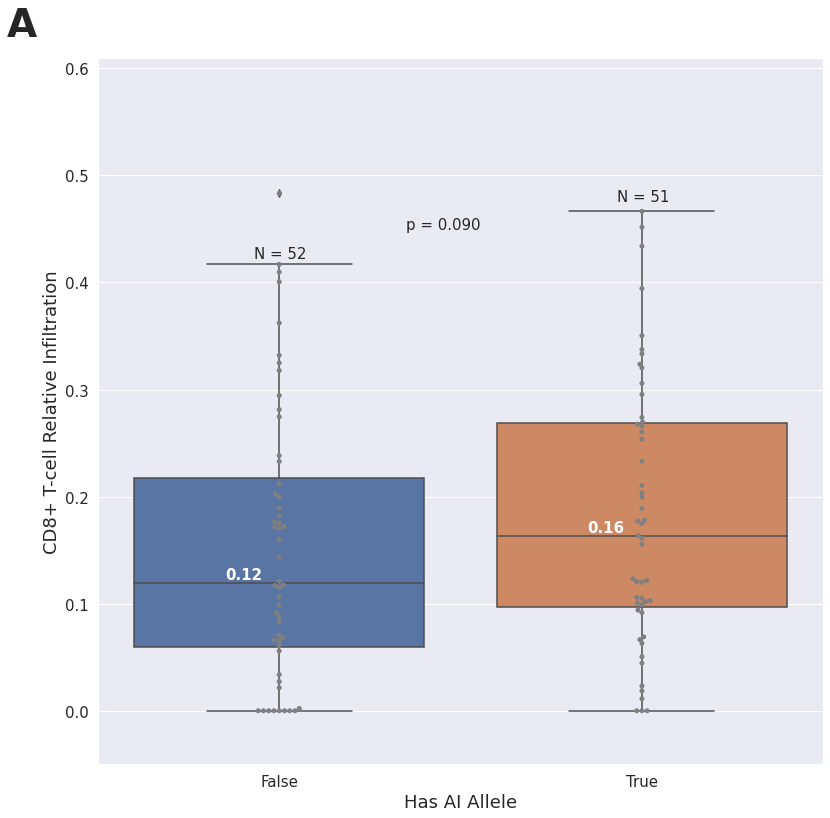

In [22]:
#Plot Results
plt.figure(figsize = (13, 13))

ax = sns.boxplot(x = "HasProtection", y = "T cells CD8", data = masterDF)
sns.swarmplot(x = "HasProtection", y = "T cells CD8", data = masterDF, dodge = True, color = "grey")
plt.ylim(-0.05, 0.61)

plt.xlabel("Has AI Allele", fontsize = 18)
plt.ylabel("CD8+ T-cell Relative Infiltration", fontsize = 18)
plt.text(0.35, 0.45, "p = {0:.3f}".format(pCD8AndAI), fontsize = 15)

plt.text(0.93, .476, "N = {}".format(masterDF[masterDF.HasProtection].shape[0]), fontsize = 15)
plt.text(-0.07, .423, "N = {}".format(masterDF[~masterDF.HasProtection].shape[0]), fontsize = 15)
plt.text(0.85, .167, "{0:.2f}".format(np.median(masterDF[masterDF.HasProtection]["T cells CD8"])), color = "white", fontsize = 15, fontweight = "bold")
plt.text(-0.15, .123, "{0:.2f}".format(np.median(masterDF[~masterDF.HasProtection]["T cells CD8"])), color = "white", fontsize = 15, fontweight = "bold")

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
ax.text(-0.75, 0.63, string.ascii_uppercase[0], size=39, weight='bold')

#### Supplementary Figure 15B:

Statistical Test: MWU test for CD8+ T-cell infiltration

In [23]:
#run statistical test
_, pCarryingV600E = mannwhitneyu(masterDF[(masterDF.HasBRAFV600E)]["T cells CD8"], masterDF[(masterDF["HasBRAFV600E"] == False)]["T cells CD8"])
logging.info(f"MWU Test p-value: {pCarryingV600E}")

MWU Test p-value: 0.14725382794437475


Text(-0.75, 0.63, 'B')

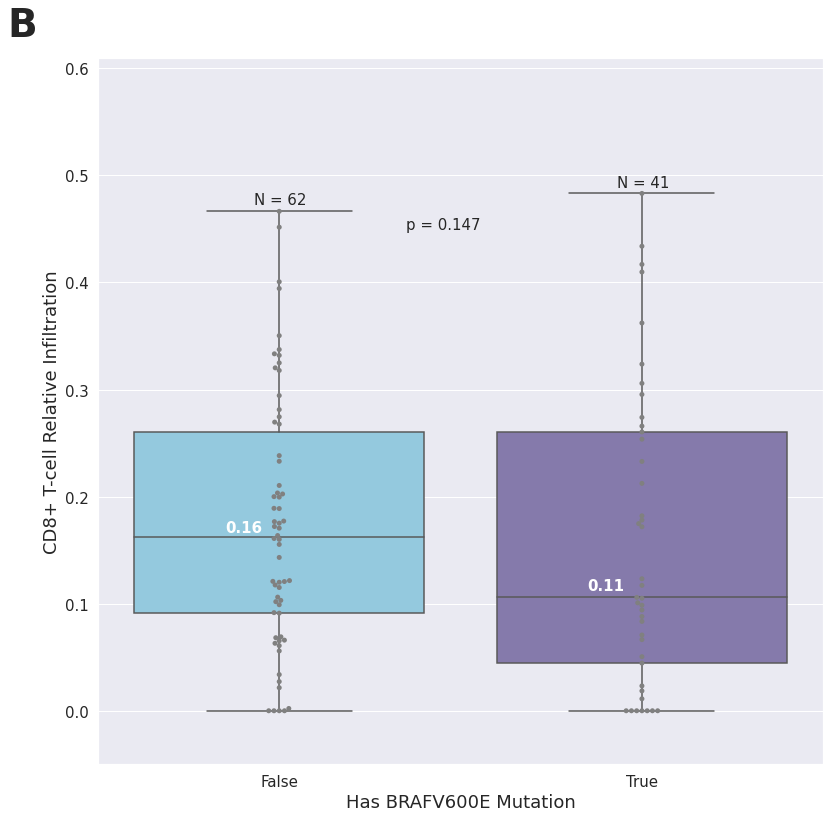

In [24]:
#plot results
plt.figure(figsize = (13, 13))

brafColorPalette = {False: "skyblue", True:"m"}
ax = sns.boxplot(x = "HasBRAFV600E", y = "T cells CD8", data = masterDF, palette = brafColorPalette)
sns.swarmplot(x = "HasBRAFV600E", y = "T cells CD8", data = masterDF, dodge = True, color = "grey")
plt.ylim(-0.05, 0.61)

plt.ylabel("CD8+ T-cell Relative Infiltration", fontsize = 18)
plt.xlabel("Has BRAFV600E Mutation", fontsize = 18)
plt.text(0.35, 0.45, "p = {0:.3f}".format(pCarryingV600E), fontsize = 15)

plt.text(0.93, .489, "N = {}".format(masterDF[masterDF.HasBRAFV600E].shape[0]), fontsize = 15)
plt.text(-0.07, .473, "N = {}".format(masterDF[~masterDF.HasBRAFV600E].shape[0]), fontsize = 15)
plt.text(0.85, .113, "{0:.2f}".format(np.median(masterDF[masterDF.HasBRAFV600E]["T cells CD8"])), color = "white", fontsize = 15, fontweight = "bold")
plt.text(-0.15, .167, "{0:.2f}".format(np.median(masterDF[~masterDF.HasBRAFV600E]["T cells CD8"])), color = "white", fontsize = 15, fontweight = "bold")

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)

ax.text(-0.75, 0.63, string.ascii_uppercase[1], size=39, weight='bold')

## 2. Regulatory T-Cell Infiltration Analyses:

### Figure 1B: Treg Infiltration in MHC-I AI Carriers 

Statistical Test: MWU test for regulatory T-cell infiltration

In [25]:
#run statistical test
_, pTReg = mannwhitneyu(masterDF[masterDF.HasProtection]["T cells regulatory (Tregs)"], masterDF[~masterDF.HasProtection]["T cells regulatory (Tregs)"])
logging.info(f"MWU Test p-value: {pTReg}")

MWU Test p-value: 0.04801774957031476


Text(-0.71, 0.23, 'B')

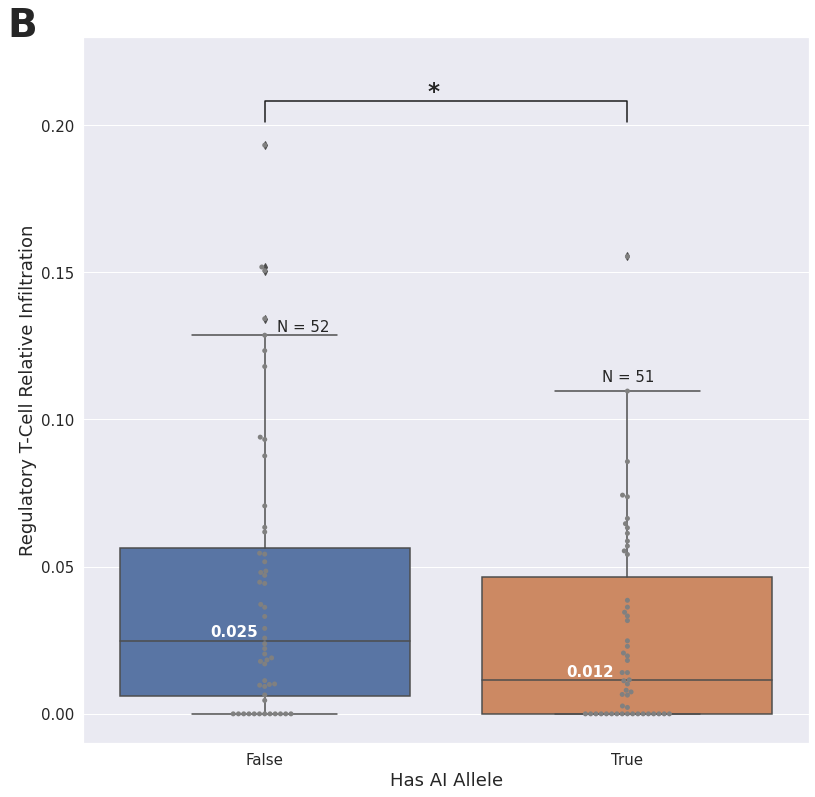

In [26]:
#plot results
plt.figure(figsize = (13, 13))

sns.boxplot(x = "HasProtection", y = "T cells regulatory (Tregs)", data = masterDF)
sns.swarmplot(x = "HasProtection", y = "T cells regulatory (Tregs)", data = masterDF, dodge = True, color = "grey")
plt.ylim(-0.01, 0.23)

plt.xlabel("Has AI Allele", fontsize = 18)
plt.ylabel("Regulatory T-Cell Relative Infiltration", fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.text(0.37, 0.16, "p = {0:.3f}".format(pTReg), fontsize = 15, fontweight = "bold")

plt.text(0.93, .113, "N = {}".format(masterDF[masterDF.HasProtection].shape[0]), fontsize = 15)
plt.text(0.035, .13, "N = {}".format(masterDF[~masterDF.HasProtection].shape[0]), fontsize = 15)
plt.text(0.83, .0126, "{0:.3f}".format(np.median(masterDF[masterDF.HasProtection]["T cells regulatory (Tregs)"])), color = "white", fontsize = 15, fontweight = "bold")
plt.text(-0.15, .0263, "{0:.3f}".format(np.median(masterDF[~masterDF.HasProtection]["T cells regulatory (Tregs)"])), color = "white", fontsize = 15, fontweight = "bold")

plt.plot([0,0,1,1], [0.201, 0.208, 0.208, 0.201], lw = 1.5, c = 'k')
plt.text(0.45, 0.209, "*", fontsize = 23, fontweight = "bold")

plt.text(-0.71, 0.23, string.ascii_uppercase[1], size=39, weight='bold')

### Supplementary Figure 5F and G: Regulatory T-cell Infiltration in HLA-A*02:01 Carriers

#### Supplementary Figure 5F: Regulatory T-cell infiltration in individuals carrying ONLY HLA-A*02:01 (i.e., no AI alleles)

Statistical Test: MWU test for regulatory T-cell infiltration

In [27]:
#run statistical test
_, pTregA201Only = mannwhitneyu(masterDF[(masterDF.OnlyA0201)]["T cells regulatory (Tregs)"], masterDF[~(masterDF.OnlyA0201)]["T cells regulatory (Tregs)"])
logging.info(f"MWU Test p-value: {pTregA201Only}")

MWU Test p-value: 0.2741885642835976


Text(-0.71, 0.23, 'F')

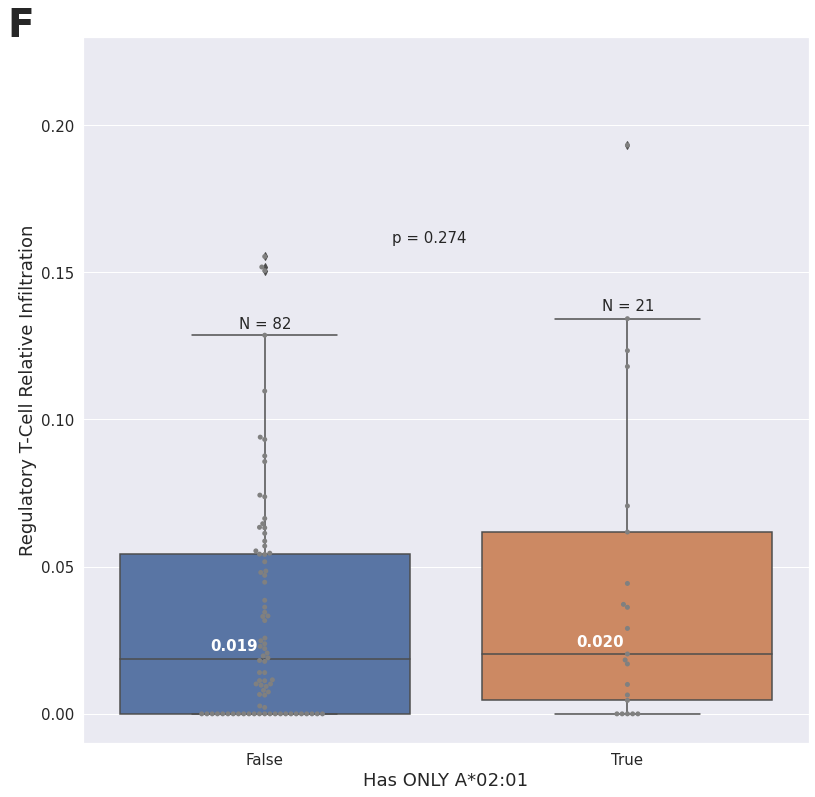

In [28]:
#plot results
plt.figure(figsize = (13, 13))

sns.boxplot(x = "OnlyA0201", y = "T cells regulatory (Tregs)", data = masterDF)
sns.swarmplot(x = "OnlyA0201", y = "T cells regulatory (Tregs)", data = masterDF, dodge = True, color = "grey")
plt.ylim(-0.01, 0.23)

plt.xlabel("Has ONLY A*02:01", fontsize = 18)
plt.ylabel("Regulatory T-Cell Relative Infiltration", fontsize = 18)
plt.text(0.35, 0.16, "p = {0:.3f}".format(pTregA201Only), fontsize = 15)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.text(0.93, .137, "N = {}".format(masterDF[masterDF.OnlyA0201].shape[0]), fontsize = 15)
plt.text(-0.07, .131, "N = {}".format(masterDF[~masterDF.OnlyA0201].shape[0]), fontsize = 15)
plt.text(-0.15, 0.0215, "{0:.3f}".format(np.median(masterDF[~masterDF.OnlyA0201]["T cells regulatory (Tregs)"])), fontsize = 15, color = "white", weight = "bold")
plt.text(0.86, 0.023, "{0:.3f}".format(np.median(masterDF[masterDF.OnlyA0201]["T cells regulatory (Tregs)"])), fontsize = 15, color = "white", weight = "bold")

plt.text(-0.71, 0.23, string.ascii_uppercase[5], size=39, weight='bold')

#### Supplementary Figure 5G: Regulatory T-cell infiltration in individuals carrying HLA-A*02:01 independent of other alleles carried

Statistical Test: MWU test for regulatory T-cell infiltration

In [29]:
#run statistical test
_, pTregA201All = mannwhitneyu(masterDF[(masterDF.HasA0201)]["T cells regulatory (Tregs)"], masterDF[~(masterDF.HasA0201)]["T cells regulatory (Tregs)"])
logging.info(f"MWU Test p-value: {pTregA201All}")

MWU Test p-value: 0.4502136860574117


Text(-0.71, 0.23, 'G')

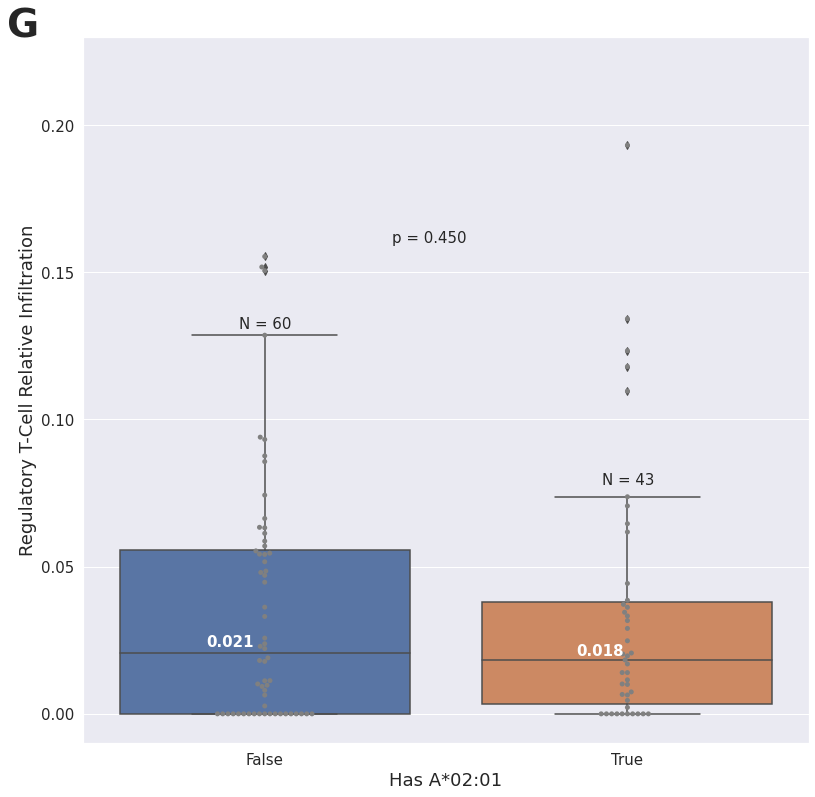

In [30]:
#plot results
plt.figure(figsize = (13, 13))

sns.boxplot(x = "HasA0201", y = "T cells regulatory (Tregs)", data = masterDF)
sns.swarmplot(x = "HasA0201", y = "T cells regulatory (Tregs)", data = masterDF, dodge = True, color = "grey")
plt.ylim(-0.01, 0.23)

plt.xlabel("Has A*02:01", fontsize = 18)
plt.ylabel("Regulatory T-Cell Relative Infiltration", fontsize = 18)
plt.text(0.35, 0.16, "p = {0:.3f}".format(pTregA201All), fontsize = 15)

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.text(0.93, .078, "N = {}".format(masterDF[masterDF.HasA0201].shape[0]), fontsize = 15)
plt.text(-0.07, .131, "N = {}".format(masterDF[~masterDF.HasA0201].shape[0]), fontsize = 15)
plt.text(-0.16, 0.023, "{0:.3f}".format(np.median(masterDF[~masterDF.HasA0201]["T cells regulatory (Tregs)"])), fontsize = 15, color = "white", weight = "bold")
plt.text(0.86, 0.02, "{0:.3f}".format(np.median(masterDF[masterDF.HasA0201]["T cells regulatory (Tregs)"])), fontsize = 15, color = "white", weight = "bold")

plt.text(-0.71, 0.23, string.ascii_uppercase[6], size=39, weight='bold')